In [1]:
%load_ext autoreload
%autoreload 2

# Assess the prompt specificity of the latent space

# Imports

In [82]:
from evoscaper.model.sampling import sample_reconstructions
from evoscaper.model.vae import sample_z
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from bioreaction.misc.misc import load_json_as_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
import os
import torch
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Load the data and models

In [3]:
top_write_dir = os.path.join(
    'data', '13_prompt_specificity', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

fn_saves = [os.path.join('data', '01_cvae', '2025_02_25__12_42_34', 'saves_2025_02_25__12_42_34_ds0211_sp_KL2e4'),
            os.path.join('data', '01_cvae', '2025_02_23__18_41_24', 'saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4')]
fn_hpos = [os.path.join('data', '01_cvae', '2025_02_25__12_42_34', 'hpos_all.json'),
           os.path.join('data', '01_cvae', '2025_02_23__18_41_24', 'hpos_all.json')]
hpos_all = [pd.Series(load_json_as_dict(fn)) for fn in fn_hpos]
saves_models = [load_json_as_dict(fn) for fn in fn_saves]

params_models = {i: arrayise(saves_loaded[str(list(saves_loaded.keys(
))[-1])]['params']) for i, saves_loaded in enumerate(saves_models)}

print('top_write_dir:', top_write_dir)
print('fn_saves:', fn_saves)
print('data:', [hpos['filenames_train_table'] for hpos in hpos_all])


top_write_dir: data/13_prompt_specificity/2025_02_26__14_53_17
fn_saves: ['data/01_cvae/2025_02_25__12_42_34/saves_2025_02_25__12_42_34_ds0211_sp_KL2e4', 'data/01_cvae/2025_02_23__18_41_24/saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4']
data: ['./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json', './data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json']


In [106]:
def bin_array(data, num_bins=10):
    original_shape = data.shape
    flattened_data = data.flatten()
    bin_edges = np.linspace(flattened_data.min(), flattened_data.max(), num_bins + 1)
    bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    bin_indices = np.clip(np.digitize(flattened_data, bin_edges) - 1, 0, num_bins - 1)
    binned_data = np.array([bin_means[idx] for idx in bin_indices])
    binned_data = binned_data.reshape(original_shape)
    bin_labels = [f"Bin {i}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}), Mean: {bin_means[i]:.2f}"
                 for i in range(num_bins)]
    return binned_data, bin_edges, bin_labels


eval_n_to_sample = int(1e4)
models_vars = {}
for i, hpos in enumerate(hpos_all):
    (
        rng, rng_model, rng_dataset,
        config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
        data, x_cols, df,
        x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
        total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
        _,
        encoder, decoder, model, h2mu, h2logvar, reparam
    ) = init_from_hpos(hpos)
    
    h_all = encoder(params_models[i], rng, np.concatenate([x, cond], axis=-1))
    h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

    mu = h2mu(params_models[i], rng, h_all)
    logvar = h2logvar(params_models[i], rng, h_all)
    z_all = sample_z(mu, logvar, rng, deterministic=False)

    cond_rev_all = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
        cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
    # cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
    x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()

    # x_bin_all, edges, labels = bin_array(x_rev_all, num_bins=10)
    # x_bin_all = np.round(x_bin_all, 1)
    # fake_circuits = decoder(params_models[i], rng, np.concatenate([z_all, cond_rev_all], axis=-1))
    
    fake_circuits, z, sampled_cond = sample_reconstructions(params_models[i], rng, decoder,
                                                            n_categories=config_norm_y.categorical_n_bins if config_norm_y.categorical_n_bins else 10,
                                                            n_to_sample=eval_n_to_sample, hidden_size=config_model.hidden_size,
                                                            x_datanormaliser=x_datanormaliser, x_methods_preprocessing=x_methods_preprocessing,
                                                            objective_cols=config_dataset.objective_col,
                                                            use_binned_sampling=True, use_onehot=config_norm_y.categorical_onehot,
                                                            cond_min=cond.min(), cond_max=cond.max())
    
    models_vars[i] = [h_all, z_all, x, cond, x_rev_all, cond_rev_all, fake_circuits, sampled_cond]



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Calculate mutual information between condition and latent space


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

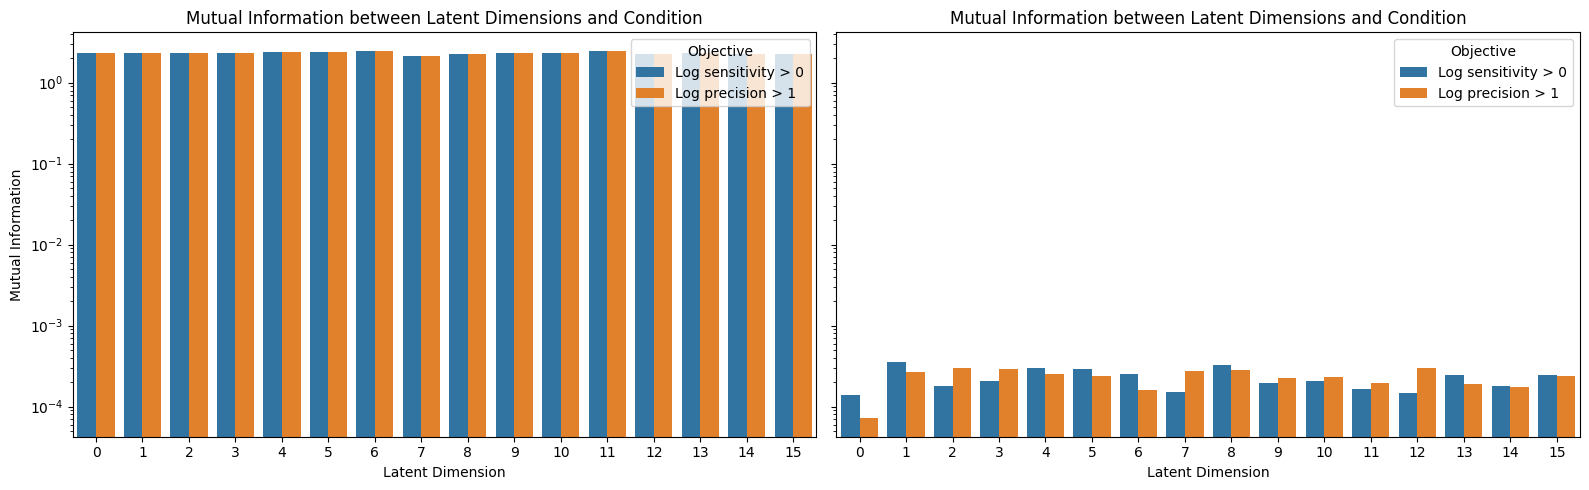

Average mutual information across dimensions: 0.000


In [5]:
# Reshape z_all and condition arrays to 2D
nrows = 1 # len(config_dataset.objective_col)
ncols = len(saves_models)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)
for im, (k, m) in enumerate(models_vars.items()):
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, fake_circuits, sampled_cond = m

    z_flat = z_all.reshape(-1, z_all.shape[-1])

    # Discretize the continuous latent dimensions using KBinsDiscretizer
    n_bins = 20
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    z_discrete = discretizer.fit_transform(z_flat)

    # Calculate MI between each latent dimension and condition
    mis = pd.DataFrame()
    for idx_obj, objective_col in enumerate(config_dataset.objective_col):
        mi_scores = []
        for i in range(z_discrete.shape[1]):
            mi = mutual_info_score(z_discrete[:, i], cond_rev_all[..., idx_obj])
            mi_scores.append(mi)
        mis[objective_col] = mi_scores
    mis = mis.reset_index().rename(columns={'index': 'Latent Dimension'})
    mis = mis.melt(id_vars='Latent Dimension', var_name='Objective', value_name='Mutual Information')

    # Plot MI scores
    sns.barplot(mis, x='Latent Dimension', y='Mutual Information', hue='Objective', ax=axs[im])
    # plt.xlabel('Latent Dimension')
    # plt.ylabel('Mutual Information with Condition')
    axs[im].set_title('Mutual Information between Latent Dimensions and Condition')
    axs[im].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutual_information.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Print average MI
print(f"Average mutual information across dimensions: {np.mean(mi_scores):.3f}")


# Other approaches

- Conditional Latent Entropy
- Cluster Separation
- KL Condition Prior
- Mutual Information Latent Condition
- Within/Total Variance Ratio
- Nearest Neighbor Condition Accuracy

In [6]:
def conditional_latent_entropy(z_samples, conditions, n_bins=20):
    """
    Calculate entropy of latent distributions conditioned on different prompts.
    Lower entropy indicates more specific prompt response.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE (shape: n_samples × latent_dim)
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    n_bins : int
        Number of bins for discretizing the latent space

    Returns:
    --------
    float
        Average conditional entropy across all latent dimensions
    dict
        Per-condition entropy values
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    unique_conditions = np.unique(conditions)
    latent_dim = z_samples.shape[1]

    # Calculate entropy for each condition and each latent dimension
    condition_entropies = {}
    avg_entropies = np.zeros(latent_dim)

    for condition in unique_conditions:
        condition_mask = (conditions == condition)
        condition_z = z_samples[condition_mask]

        # Skip if too few samples
        if len(condition_z) < 5:
            continue

        dim_entropies = []
        for dim in range(latent_dim):
            # Discretize the dimension
            hist, _ = np.histogram(
                condition_z[:, dim], bins=n_bins, density=True)
            # Add small epsilon to avoid log(0)
            hist = hist + 1e-10
            hist = hist / np.sum(hist)
            dim_entropy = entropy(hist)
            dim_entropies.append(dim_entropy)
            avg_entropies[dim] += dim_entropy * len(condition_z)

        condition_entropies[condition] = np.mean(dim_entropies)

    # Normalize by total samples
    avg_entropies = avg_entropies / len(z_samples)
    overall_entropy = np.mean(avg_entropies)

    return overall_entropy, condition_entropies


def latent_cluster_separation(z_samples, conditions):
    """
    Measure how well-separated the latent clusters are for different prompts.
    Higher values indicate more specific prompt encoding.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample

    Returns:
    --------
    float
        Silhouette score measuring cluster separation
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    # Only calculate if we have enough samples and conditions
    unique_conditions = np.unique(conditions)
    if len(unique_conditions) < 2 or len(z_samples) < len(unique_conditions) * 3:
        return 0.0

    try:
        # Calculate silhouette score (how well clusters are separated)
        sil_score = silhouette_score(z_samples, conditions)
        return sil_score
    except ValueError:
        # Handle potential errors in silhouette calculation
        return 0.0


def kl_condition_prior(encoder_model, dataloader, condition_embedding_fn):
    """
    Measure KL divergence between condition-specific latent distributions and prior.
    Higher KL indicates more condition-specific encodings.

    Parameters:
    -----------
    encoder_model : torch.nn.Module
        VAE encoder model that outputs mean and log variance
    dataloader : torch.utils.data.DataLoader
        Data loader with input data and conditions
    condition_embedding_fn : callable
        Function to embed conditions into the format expected by the encoder

    Returns:
    --------
    dict
        Dictionary with per-condition KL divergence values
    """
    device = next(encoder_model.parameters()).device
    condition_kl_divs = {}
    condition_sample_counts = {}

    for batch in dataloader:
        # Unpack batch (adjust based on your specific dataloader)
        inputs, conditions = batch
        inputs = inputs.to(device)

        # Get condition embeddings
        condition_embeddings = condition_embedding_fn(conditions).to(device)

        # Get means and log variances from encoder
        mu, logvar = encoder_model(inputs, condition_embeddings)

        # Calculate KL divergence with standard normal prior
        # KL(N(μ,σ²) || N(0,1)) = 0.5 * (μ² + σ² - log(σ²) - 1)
        kl_divs = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1)
        kl_divs = kl_divs.sum(dim=1)  # Sum over latent dimensions

        # Group by condition
        for i, condition in enumerate(conditions):
            cond_key = str(condition.item())
            if cond_key not in condition_kl_divs:
                condition_kl_divs[cond_key] = 0
                condition_sample_counts[cond_key] = 0

            condition_kl_divs[cond_key] += kl_divs[i].item()
            condition_sample_counts[cond_key] += 1

    # Calculate averages
    for cond_key in condition_kl_divs:
        if condition_sample_counts[cond_key] > 0:
            condition_kl_divs[cond_key] /= condition_sample_counts[cond_key]

    return condition_kl_divs


def mutual_information_latent_condition(z_samples, conditions, n_bins=20):
    """
    Estimate mutual information between latent space and conditions.
    Higher MI indicates stronger conditioning.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    n_bins : int
        Number of bins for discretizing the latent space

    Returns:
    --------
    float
        Estimated mutual information
    list
        Per-dimension mutual information values
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    latent_dim = z_samples.shape[1]
    mi_per_dim = []

    for dim in range(latent_dim):
        # Discretize latent dimension
        z_dim = z_samples[:, dim]
        z_bins = np.linspace(z_dim.min(), z_dim.max(), n_bins + 1)
        z_binned = np.digitize(z_dim, z_bins[1:-1])

        # Calculate joint distribution P(z,c)
        joint_counts = np.zeros((n_bins, len(np.unique(conditions))))
        for z_val, c_val in zip(z_binned, conditions):
            c_idx = np.where(np.unique(conditions) == c_val)[0][0]
            joint_counts[z_val-1, c_idx] += 1

        # Convert to probability
        joint_prob = joint_counts / np.sum(joint_counts)

        # Calculate marginals
        z_prob = joint_prob.sum(axis=1)
        c_prob = joint_prob.sum(axis=0)

        # Calculate entropies (add small epsilon to avoid log(0))
        eps = 1e-10
        Hz = entropy(z_prob + eps)
        Hc = entropy(c_prob + eps)

        # Flatten and calculate joint entropy
        joint_prob_flat = joint_prob.flatten() + eps
        joint_prob_flat = joint_prob_flat / np.sum(joint_prob_flat)
        Hzc = entropy(joint_prob_flat)

        # Calculate mutual information I(Z;C) = H(Z) + H(C) - H(Z,C)
        mi = Hz + Hc - Hzc
        mi_per_dim.append(mi)

    return np.mean(mi_per_dim), mi_per_dim


def within_condition_variance_ratio(z_samples, conditions):
    """
    Calculate the ratio of within-condition variance to total variance.
    Lower values indicate more condition-specific latent representations.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample

    Returns:
    --------
    float
        Ratio of within-condition variance to total variance
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    unique_conditions = np.unique(conditions)

    # Calculate total variance
    total_variance = np.var(z_samples, axis=0).sum()

    # Calculate within-condition variance
    within_variance = 0
    for condition in unique_conditions:
        condition_mask = (conditions == condition)
        condition_z = z_samples[condition_mask]
        if len(condition_z) > 1:  # Need at least 2 samples to calculate variance
            within_variance += np.var(condition_z,
                                      axis=0).sum() * len(condition_z)

    within_variance /= len(z_samples)

    # Return ratio (bounded between 0 and 1)
    if total_variance > 0:
        return within_variance / total_variance
    else:
        return 1.0  # If total variance is 0, return 1 (no separation)


def reduce(z_samples, method='tsne'):

    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    # Reduce dimensionality to 2D
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = PCA(n_components=2, random_state=42)

    z_2d = reducer.fit_transform(z_samples)
    return z_2d


def visualize_latent_by_condition_all(z_samples, conditions, condition_labels, method='tsne', title=None):
    """
    Visualize latent space colored by conditions for all dimensions.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray

    """
    # Reduce dimensionality
    z_2d = reduce(z_samples, method)

    ncols = len(condition_labels)
    fig, axs = plt.subplots(1, ncols, figsize=(8*ncols, 5))
    for idx_cond, condition_label in enumerate(condition_labels):
        df = pd.DataFrame(data=np.concatenate([z_2d[..., 0], z_2d[..., 1], conditions[..., idx_cond]]).reshape(3, -1).T,
                          columns=['Dimension 1', 'Dimension 2', condition_label])
        sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2',
                        hue=condition_label, ax=axs[idx_cond], palette='viridis')
        axs[idx_cond].set_title(f'{condition_label}')

    plt.suptitle(
        title if title else f'Latent Space Visualization by Condition ({method.upper()})')
    plt.tight_layout()
    plt.show()


def visualize_latent_by_condition(z_samples, conditions, method='tsne', title=None):
    """
    Visualize latent space colored by conditions.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    method : str
        Dimensionality reduction method ('pca' or 'tsne')
    title : str
        Plot title
    """
    # Reduce dimensionality
    z_2d = reduce(z_samples, method)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    unique_conditions = np.unique(conditions)

    for condition in unique_conditions:
        condition_mask = (conditions == condition)
        plt.scatter(
            z_2d[condition_mask, 0],
            z_2d[condition_mask, 1],
            label=f"Condition {condition}",
            alpha=0.7
        )

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    if title:
        plt.title(title)
    else:
        plt.title(
            f'Latent Space Visualization by Condition ({method.upper()})')

    plt.legend()
    plt.grid(alpha=0.3)

    return plt


def nearest_neighbor_condition_accuracy(z_samples, conditions, k=5):
    """
    Measure how well conditions can be identified from nearest neighbors in latent space.
    Higher accuracy indicates more condition-specific clusters.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    k : int
        Number of nearest neighbors to consider

    Returns:
    --------
    float
        Average accuracy of condition prediction from nearest neighbors
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    # Ensure k is not larger than the number of samples minus one
    k = min(k, len(z_samples) - 1)

    # Find k-nearest neighbors for each sample
    # +1 because the sample itself is included
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(z_samples)
    distances, indices = nn.kneighbors(z_samples)

    # Calculate accuracy for each sample
    accuracies = []
    for i in range(len(z_samples)):
        # Skip the first index (which is the sample itself)
        neighbor_indices = indices[i, 1:]
        neighbor_conditions = conditions[neighbor_indices]

        # Calculate accuracy
        same_condition = (neighbor_conditions == conditions[i])
        accuracy = np.mean(same_condition)
        accuracies.append(accuracy)

    return np.mean(accuracies)


def evaluate_all_metrics(z_samples, conditions, title="Prompt Specificity Metrics"):
    """
    Calculate and display all metrics for latent space prompt specificity.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    title : str
        Title for the results
    """
    if isinstance(z_samples, torch.Tensor):
        z_samples = z_samples.detach().cpu().numpy()

    # Calculate all metrics
    entropy_val, per_cond_entropy = conditional_latent_entropy(
        z_samples, conditions)
    cluster_sep = latent_cluster_separation(z_samples, conditions)
    mi_val, mi_per_dim = mutual_information_latent_condition(
        z_samples, conditions)
    variance_ratio = within_condition_variance_ratio(z_samples, conditions)
    nn_accuracy = nearest_neighbor_condition_accuracy(z_samples, conditions)

    # Format metric values
    results = {
        "Conditional Entropy": f"{entropy_val:.4f} (lower is more specific)",
        "Cluster Separation (Silhouette)": f"{cluster_sep:.4f} (higher is more specific)",
        "Mutual Information": f"{mi_val:.4f} (higher is more specific)",
        "Within/Total Variance Ratio": f"{variance_ratio:.4f} (lower is more specific)",
        "NN Condition Accuracy": f"{nn_accuracy:.4f} (higher is more specific)"
    }

    # Print results
    print(f"===== {title} =====")
    for metric, value in results.items():
        print(f"{metric}: {value}")

    # Return the raw values for further analysis
    return {
        "conditional_entropy": entropy_val,
        "per_condition_entropy": per_cond_entropy,
        "cluster_separation": cluster_sep,
        "mutual_information": mi_val,
        "mutual_information_per_dim": mi_per_dim,
        "variance_ratio": variance_ratio,
        "nn_accuracy": nn_accuracy
    }

Model 0

Log sensitivity > 0
===== Prompt Specificity Metrics =====
Conditional Entropy: 0.0000 (lower is more specific)
Cluster Separation (Silhouette): 0.0000 (higher is more specific)
Mutual Information: 2.5314 (higher is more specific)
Within/Total Variance Ratio: 0.0007 (lower is more specific)
NN Condition Accuracy: 0.0000 (higher is more specific)
Log precision > 1
===== Prompt Specificity Metrics =====
Conditional Entropy: 0.0000 (lower is more specific)
Cluster Separation (Silhouette): 0.0000 (higher is more specific)
Mutual Information: 2.5326 (higher is more specific)
Within/Total Variance Ratio: 0.0000 (lower is more specific)
NN Condition Accuracy: 0.0000 (higher is more specific)


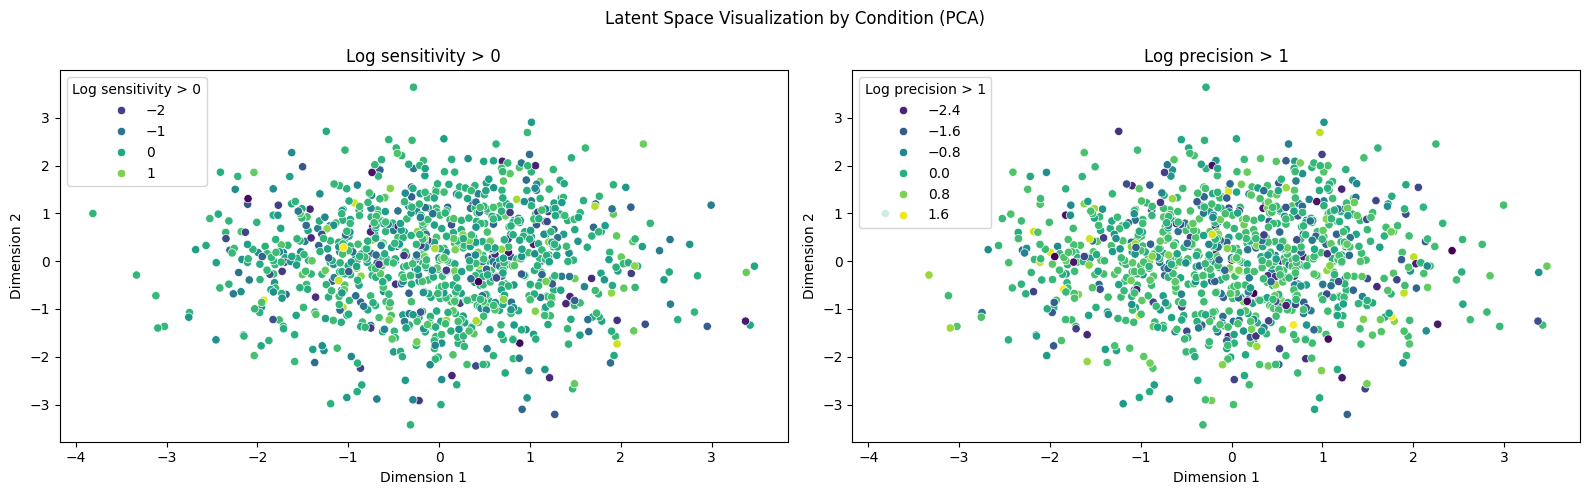

Model 1

Log sensitivity > 0
===== Prompt Specificity Metrics =====
Conditional Entropy: 2.5797 (lower is more specific)
Cluster Separation (Silhouette): -0.0021 (higher is more specific)
Mutual Information: 0.0093 (higher is more specific)
Within/Total Variance Ratio: 0.9996 (lower is more specific)
NN Condition Accuracy: 0.5168 (higher is more specific)
Log precision > 1
===== Prompt Specificity Metrics =====
Conditional Entropy: 2.5909 (lower is more specific)
Cluster Separation (Silhouette): -0.0002 (higher is more specific)
Mutual Information: 0.0105 (higher is more specific)
Within/Total Variance Ratio: 0.9990 (lower is more specific)
NN Condition Accuracy: 0.5282 (higher is more specific)


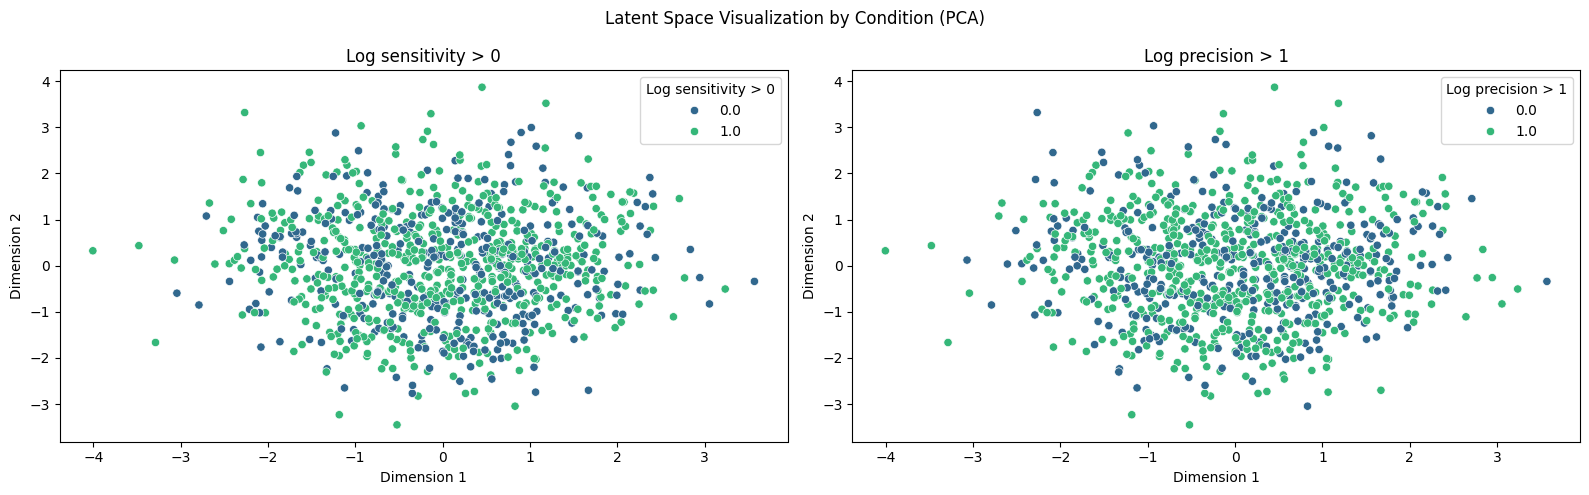

In [7]:
# Example usage:
def main():
    # Simulate latent vectors for testing
    latent_dim = 10
    n_samples = 500
    n_conditions = 5
    
    # Generate random latent vectors (in practice, these would come from your cVAE)
    z_samples = np.random.randn(n_samples, latent_dim)

    # Generate random conditions
    conditions = np.random.randint(0, n_conditions, size=n_samples)
    
    # Add some correlation between conditions and certain latent dimensions
    for i in range(n_samples):
        z_samples[i, 0] += conditions[i] * 0.5  # First dimension correlates with condition
        z_samples[i, 1] -= conditions[i] * 0.3  # Second dimension negatively correlates
    
    # Evaluate all metrics
    results = evaluate_all_metrics(z_samples, conditions)
    
    # Visualize
    visualize_latent_by_condition(z_samples, conditions, method='tsne')
    plt.show()
    

for im, (k, m) in enumerate(models_vars.items()):
    print(f'Model {k}\n')
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, fake_circuits, sampled_cond = m
    # Evaluate all metrics
    n_show = 1000 #len(z_all)
    z_samples = z_all[:n_show]
    conditions = cond_rev_all[:n_show]
    # conditions = cond_rev_all[..., idx_obj][:n_show]

    for idx_obj, obj_col in enumerate(config_dataset.objective_col):
        print(obj_col)
        results = evaluate_all_metrics(z_samples, conditions[..., idx_obj])

    # Visualize
    visualize_latent_by_condition_all(z_samples, conditions, config_dataset.objective_col, method='pca')
    # visualize_latent_by_condition(z_samples, conditions, method='tsne')
    # visualize_latent_by_condition(z_samples, conditions, method='pca')
    plt.show()

# Visualise original

Model 0, Avg KL: 0.21
Model 1, Avg KL: 0.12


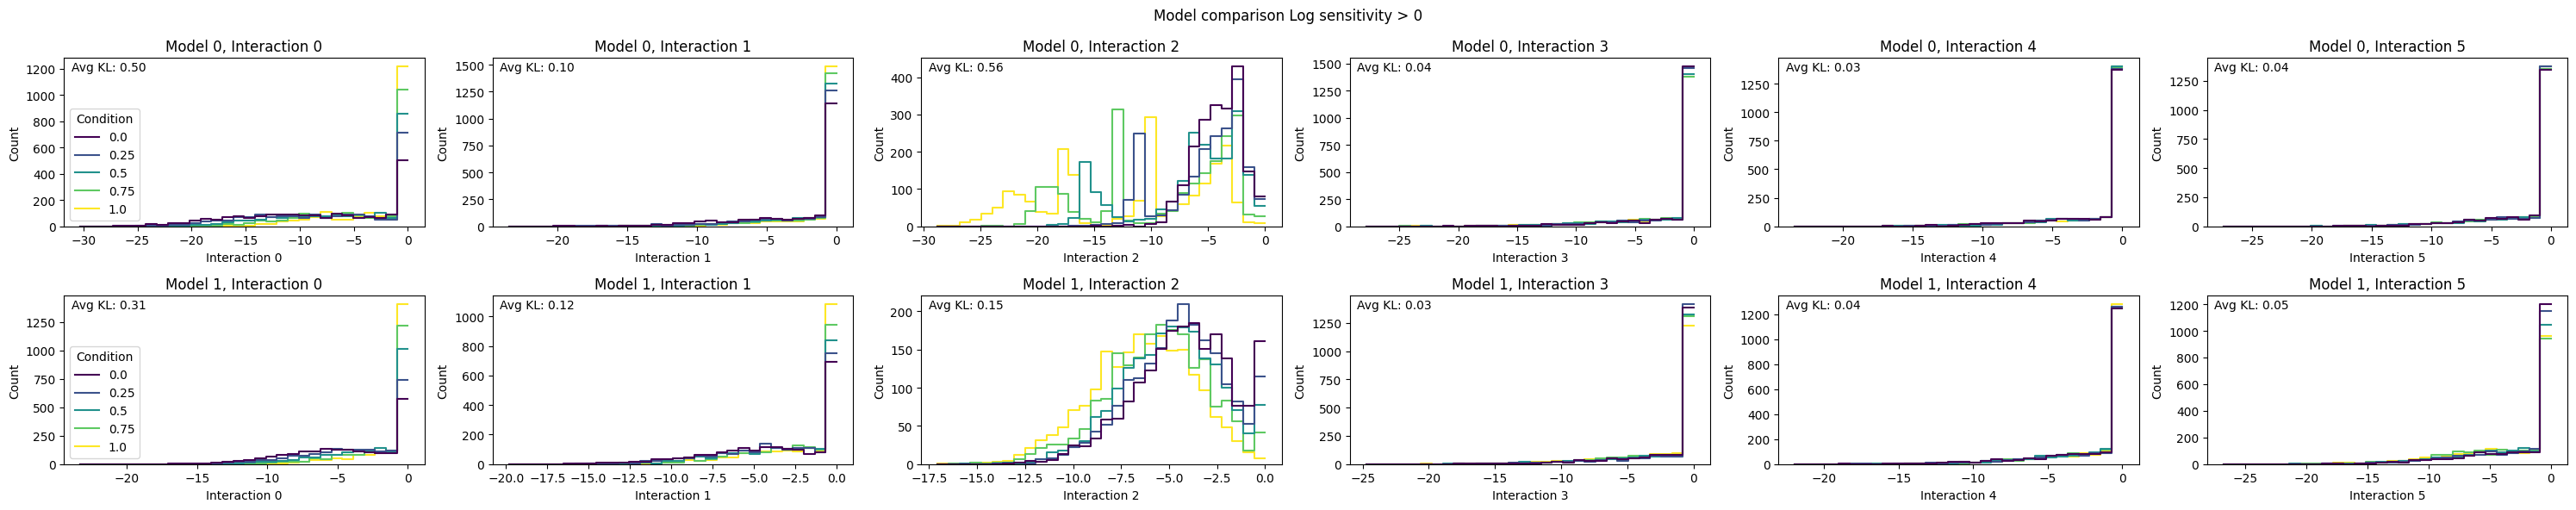

In [107]:
idx_obj = 0
nrows = len(models_vars)
ncols = fake_circuits.shape[-1]
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
for im, (k, m) in enumerate(models_vars.items()):
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, fake_circuits, sampled_cond = m
    sampled_cond_f = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
    if len(np.unique(sampled_cond)) > 10:
        sampled_cond_binned = pd.qcut(sampled_cond_f[..., idx_obj], q=10, labels=False)
    else:
        sampled_cond_binned = sampled_cond_f[..., idx_obj]
    fake_circuits_inv = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1).squeeze()
    # fake_circuits_inv = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits).reshape(np.prod(fake_circuits.shape[:-1]), -1).squeeze()
    
    # Calculate KL and show distributions
    kl_divs_avg = []
    for ie in range(fake_circuits.shape[-1]):
        # Bin conditions into 10 groups
        df = pd.DataFrame(data=np.concatenate([fake_circuits_inv[..., ie], sampled_cond_binned]).reshape(2, -1).T, columns=[f'Interaction {ie}', 'Condition'])
        sns.histplot(data=df, x=f'Interaction {ie}', hue='Condition', palette='viridis' if len(np.unique(sampled_cond_binned)) > 2 else None, 
                     element='step', multiple='layer', bins=30, ax=axs[im, ie],
                     fill=False, legend=True if ie == 0 else False)
        axs[im, ie].set_title(f'Model {k}, Interaction {ie}')
        
        # Calculate KL divergence between distributions for each condition group
        kl_divs = []
        unique_conds = np.unique(sampled_cond_binned)
        for cond1 in unique_conds:
            dist1 = fake_circuits_inv[sampled_cond_binned == cond1, ie]
            hist1, bins = np.histogram(dist1, bins=30, density=True)
            hist1 = hist1 + 1e-10  # Add small constant to avoid division by zero
            
            for cond2 in unique_conds:
                if cond1 >= cond2:
                    continue
                dist2 = fake_circuits_inv[sampled_cond_binned == cond2, ie]
                hist2, _ = np.histogram(dist2, bins=bins, density=True)
                hist2 = hist2 + 1e-10
                
                kl_div = entropy(hist1, hist2)
                kl_divs.append((cond1, cond2, kl_div))
        
        if len(kl_divs) > 0:
            avg_kl = np.mean([x[2] for x in kl_divs])
            axs[im, ie].text(0.02, 0.98, f'Avg KL: {avg_kl:.2f}', 
                           transform=axs[im, ie].transAxes,
                           verticalalignment='top')
        kl_divs_avg.append(avg_kl)
    
    print(f'Model {k}, Avg KL: {np.mean(kl_divs_avg):.2f}')
       
plt.suptitle(f'Model comparison {config_dataset.objective_col[idx_obj]}')
plt.tight_layout()
plt.show()
